# Assignment 4
## Mouselinos Spyridon 
### December 2019
***

In [1]:
import os
### The Notebook can be excecuted in GPU-Accelerated Mode or Not by adjusting the following flag ###
use_gpu = True

In [2]:
if not use_gpu:
    ### Disable GPU ###
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
else:
    ### Enable the first available GPU ###
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import random
from sklearn.metrics import f1_score
from collections import Counter
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import MultiLabelBinarizer
import warnings
warnings.filterwarnings("ignore")

In [4]:
%matplotlib inline

# My Data Structure

* The Data were downloaded and stored in a folder named `DataFolder` at the same level as the Notebook. The folder includes the following folders/files:

    * `training-set`
    
    * `validation-set`
    
    * `test-set\dummy-class` : The dummy-class subfolder is needed for the flow_from_directory method of Keras Generator.
    
    * `train_concepts.csv` : the image IDs of the training set with their gold (i.e., known correct) tags, separated with `;`.
    
    * `val_concepts.csv` : the validation image IDs with their gold tags, separated with `;`.
    
    * `string_concepts.csv`: all the available tag IDs and their corresponding name, separated with tabs.

In [5]:
data_path = 'DataFolder/'
train_data_path = data_path + '/training-set/'
validation_data_path = data_path + '/validation-set/'
test_data_path = data_path + '/test-set/'
train_tag_id = pd.read_csv(data_path + '/train_concepts.csv')
val_tag_id = pd.read_csv(data_path + '/val_concepts.csv')
concept_id = pd.read_csv(data_path + '/string_concepts.csv', sep='\t', header=None)
concept_id.rename(columns={0: "tags", 1: "concepts"}, inplace=True)

## Data Exploration
***

* Plot some images.
* For those images, fetch their tag IDs and their tag names.

In [ ]:
### Read 3 random Train Images
rand_3_train = random.choices(os.listdir(train_data_path), k=3)


img1 = mpimg.imread(train_data_path + rand_3_train[0])
img2 = mpimg.imread(train_data_path + rand_3_train[1])
img3 = mpimg.imread(train_data_path + rand_3_train[2])


### Find their Tag ID's
img1_tags = train_tag_id[train_tag_id['image'] == rand_3_train[0].split('.')[0]]['tags'].values[0].split(';')
img2_tags = train_tag_id[train_tag_id['image'] == rand_3_train[1].split('.')[0]]['tags'].values[0].split(';')
img3_tags = train_tag_id[train_tag_id['image'] == rand_3_train[2].split('.')[0]]['tags'].values[0].split(';')


### Find their tag names
img1_names = [concept_id[concept_id['tags'] == f]['concepts'].values[0] for f in img1_tags]
img2_names = [concept_id[concept_id['tags'] == f]['concepts'].values[0] for f in img2_tags]
img3_names = [concept_id[concept_id['tags'] == f]['concepts'].values[0] for f in img3_tags]

### Plot them with their ID's and names
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (5, 11))
ax1.imshow(img1, aspect = "auto")
ax1.title.set_text(img1_tags)
ax1.set_xlabel(img1_names)
ax2.imshow(img2, aspect = "auto")
ax2.title.set_text(img2_tags)
ax2.set_xlabel(img2_names)
ax3.imshow(img3, aspect = "auto")
ax3.title.set_text(img3_tags)
ax3.set_xlabel(img3_names)
f.subplots_adjust(hspace=0.5)

In [ ]:
### Read 3 random Validation Images
rand_3_val = random.choices(os.listdir(validation_data_path), k=3)
### Plot them
img1 = mpimg.imread(validation_data_path + rand_3_val[0])
img2 = mpimg.imread(validation_data_path + rand_3_val[1])
img3 = mpimg.imread(validation_data_path + rand_3_val[2])

### Find their Tag ID's
img1_tags = val_tag_id[val_tag_id['image'] == rand_3_val[0].split('.')[0]]['tags'].values[0].split(';')
img2_tags = val_tag_id[val_tag_id['image'] == rand_3_val[1].split('.')[0]]['tags'].values[0].split(';')
img3_tags = val_tag_id[val_tag_id['image'] == rand_3_val[2].split('.')[0]]['tags'].values[0].split(';')

### Find their tag names
img1_names = [concept_id[concept_id['tags'] == f]['concepts'].values[0] for f in img1_tags]
img2_names = [concept_id[concept_id['tags'] == f]['concepts'].values[0] for f in img2_tags]
img3_names = [concept_id[concept_id['tags'] == f]['concepts'].values[0] for f in img3_tags]

### Plot them with their ID's and names
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (5, 11))
ax1.imshow(img1, aspect = "auto")
ax1.title.set_text(img1_tags)
ax1.set_xlabel(img1_names)
ax2.imshow(img2, aspect = "auto")
ax2.title.set_text(img2_tags)
ax2.set_xlabel(img2_names)
ax3.imshow(img3, aspect = "auto")
ax3.title.set_text(img3_tags)
ax3.set_xlabel(img3_names)
f.subplots_adjust(hspace=0.5)

* How many tags are there in total?
***

In [ ]:
### Let's find the total number of tag ID's
total_tag_ids = concept_id['tags'].unique().shape[0]
print("The total number of Unique CUI tags is: {}".format(total_tag_ids))

In [ ]:
### We find 5528 unique CUI tags that is consistent with the number reported on the Paper after the preprocessing the authors made (page 3)

In [ ]:
def cui_to_concept(cui_code):
    return concept_id[concept_id['tags'] == cui_code]['concepts'].values[0]

* Which ones are the most frequent?
***

In [ ]:
### Let's count the frequency in the training set.
array_of_all_train_tags = np.concatenate(train_tag_id['tags'].str.split(';').apply(lambda x: np.array(x)).values)
count_array = Counter(array_of_all_train_tags)
most_6 = count_array.most_common(6)
print("The most Common TAG id's are:")
for tag, times in most_6:
    print("CUI : {} | UMLS term : {} | Images: {}".format(tag,cui_to_concept(tag),times))

In [ ]:
### We find exactly tha same results as the authors made (page 3)

In [ ]:
### Let's count the frequency in the validation set.
array_of_all_val_tags = np.concatenate(val_tag_id['tags'].str.split(';').apply(lambda x: np.array(x)).values)
count_array = Counter(array_of_all_val_tags)
most_6 = count_array.most_common(6)
print("The most Common TAG id's are:")
for tag, times in most_6:
    print("CUI : {} | UMLS term : {} | Images: {}".format(tag,cui_to_concept(tag),times))

* How many tags are there per image?
***

In [ ]:
### Let's count the range of tags in the training set.
array_of_train_tags_per_img = train_tag_id['tags'].str.split(';').apply(lambda x: len(x)).values

In [ ]:
print("Minumum tags assigned per image: {}".format(array_of_train_tags_per_img.min()))
print("Maximum tags assigned per image: {}".format(array_of_train_tags_per_img.max()))
print("On average tags assigned per image: {}".format(int(array_of_train_tags_per_img.mean())))

In [ ]:
### Let's count the range of tags in the validation set.
array_of_val_tags_per_img = val_tag_id['tags'].str.split(';').apply(lambda x: len(x)).values

In [ ]:
print("Minumum tags assigned per image: {}".format(array_of_val_tags_per_img.min()))
print("Maximum tags assigned per image: {}".format(array_of_val_tags_per_img.max()))
print("On average tags assigned per image: {}".format(int(array_of_val_tags_per_img.mean())))

***

## Data Preprocessing

* Preprocess the images so that you can use them as input.

* You may have to preprocess the labels as well.

In [ ]:
### The first step is to create a pandas dataframe that has at one column the image name .jpg and in another column the onehot encoded labels

In [6]:
train_tag_id['tags'] = train_tag_id['tags'].str.split(';')
train_tag_id['image'] = train_tag_id['image'] + '.jpg'


val_tag_id['tags'] = val_tag_id['tags'].str.split(';')
val_tag_id['image'] = val_tag_id['image'] + '.jpg'

In [ ]:
### Note: We dont need to create and pass the labels from the UMLS terms, rather we can keep the CUI codes as labels.
### Simply, we create a dictionary to reverse-engineer the predicted code into the UMLS term when needed. 

In [ ]:
tag_to_name_dict = concept_id.set_index('tags').to_dict()['concepts']

In [ ]:
### Because the data could not fit in memory we will BATCH-PROCESS them using Keras Preprocessing Library.

In [ ]:
### First we create an Image Data Generator that will apply some transorfmations on the TRAIN images 
### in order to boost our network's robustness.
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    rescale=1./255.)

### With this image generator we choose to load a batch of 12 images from our train directory.
### Shuffle them for randomness.
### Rescale them to 72 by 72.
### And finally normalize them in the range 0-1.
### Furthermore, we also convert the labels associated with each one to multilabel encoded format.

train_datagen = datagen.flow_from_dataframe(
dataframe=train_tag_id,
directory=train_data_path,
x_col="image",
y_col="tags",
batch_size=12,
seed=1453,
shuffle=True,
class_mode="categorical",
classes= list(concept_id['tags'].unique()),
target_size=(72,72))

In [ ]:
### Our Train Data Generetor has the attributes __len__ and batch_size that we will use to get our images in batches as well as validate the number of batches we get.
print("We will perform {} iterations of {} image preprocessing steps.".format(train_datagen.__len__(), train_datagen.batch_size))

In [ ]:
### Let's get the first batch and observe its type / size

In [ ]:
print("Type: {}, Size: {}".format(type(train_datagen[0]),len(train_datagen[0])))

In [ ]:
### We can see that it is a tuple of (x_train, y_train) data. Let's see x_train data:

In [ ]:
train_datagen[0][0].shape

In [ ]:
### It contains 12 Images of 72 x 72 pixels and 3 color channels ( Channel Last Format ).
### Now let's see y_train data.

In [ ]:
train_datagen[0][1].shape

In [ ]:
### It contains 12 vectors of size 5528 with 1 at the position of the classes associated with each image and 0 elsewhere.
### So with this approach we managed to preprocess both the image as well as the labels AND make them fit into memory.

In [7]:
### Let's do the same with the validation data, only this time the only transformation needed is the rescaling.
datagen2 = ImageDataGenerator(rescale=1./255.)


val_datagen = datagen2.flow_from_dataframe(
dataframe=val_tag_id,
directory=validation_data_path,
x_col="image",
y_col="tags",
batch_size=12,
seed=1453,
shuffle=False,
class_mode="categorical",
classes= list(concept_id['tags'].unique()),
target_size=(72,72))

Found 14157 validated image filenames belonging to 5528 classes.


## Build a Baseline

* Think of a baseline classifier that you could use to to measure your efforts.

* That could be a classifier that produces always the most frequent labels.

* Alternatively (and probably better), it could be a classifier that samples from the labels based on their frequency.

In [ ]:
### Let's Create 2 Classifiers. We only need the train_y and val_y arrays,
### as the x_train and x_val data could not be used to adjust or tune any parameters in our dummy classifiers.
### For this reason we dont need to preprocess the images, instead we can use a simpler method suitable only for our labels.


mlb = MultiLabelBinarizer(classes=list(concept_id['tags'].unique()))
train_y = mlb.fit_transform(train_tag_id['tags'].values)
val_y = mlb.fit_transform(val_tag_id['tags'].values)

### Dummy Most Frequent Classifier ###

In [ ]:
dummy_clf = DummyClassifier()
dummy_clf.fit(np.zeros(train_y.shape[0]),train_y)
dummy_predictions = dummy_clf.predict(np.zeros(val_y.shape[0]))

### Now lets create a classifier that samples from the lablels ###

In [ ]:
class MySamplingClassifier:
    
    def __init__(self):
        """
            Due to the fact that the 'Random Picking' is implemented with a
            random uniform distribution, it is limited by a quantized lower bound on the probabilities it can 
            output.So some of the extremely low probabilities could not be achieved numerically.
            Thus i chose to rescale all probabilities in a greater range
            without harming the validity of the results.
        """
        self.n_classes_ = None
        self.freq_bins_ = None
        self.rescale_factor = 1000 * 1000
        return
    
    def fit(self,train_data):
        self.n_classes_ = train_data.shape[1]
        self.freq_bins_ = self.rescale_factor * (train_data.sum(axis=0) / train_data.shape[0])
        
    def predict_n_times(self,n):
        prediction = np.empty((n, self.n_classes_))
        for i in range(0,n):
            rand = np.random.uniform(low=0.0, high=self.rescale_factor, size=(1,self.n_classes_))[0]
            pred = np.less(rand,self.freq_bins_)
            prediction[i] = pred
        return prediction

In [ ]:
scl = MySamplingClassifier()
scl.fit(train_y)

In [ ]:
prob_predictions = scl.predict_n_times(val_y.shape[0])

### F1 Score Re-Implemented Here ###

In [8]:
### After inspecting the python script of the competition we can reduce it to the following function

def f1_score_calc(y_pred, y_true):
    
    ### Initialize Score ###
    total_score = 0
    ### Make Sure Data have the same Shape ###
    assert y_pred.shape == y_true.shape
    ### Initialize the number of eligible examples (examples with 0 classes in Ground Truth are ignored) ###
    
    eligible_examples = y_pred.shape[0]
    
    for idx in range(0,y_pred.shape[0]):
        pred_slice = y_pred[idx]
        true_slice = y_true[idx]
        if true_slice.sum() == 0:
            eligible_examples -= 1
        else:
            total_score += f1_score(y_true=true_slice, y_pred=pred_slice, average='binary')
    
    return total_score / eligible_examples
        

In [ ]:
### Let's see how the dummy classifier performs.
f1_score_calc(y_pred=dummy_predictions, y_true=val_y)

In [ ]:
### Let's see how the Frequency Based Sampling classifier performs.
f1_score_calc(y_pred=prob_predictions, y_true=val_y)

In [ ]:
### We dont observe any huge difference between the two methods ###

## Build a Neural Network

* Transfer Learning from DenseNet.
* We will implement a Freeze - Warmup - ReTrain Schema by:
    * Fine tuning only the last layer with an adaptive optimizer at a relatively high learning rate.
    * Re-train only the convolutional network with our linear classifier frozen using a non-adaptive optimizer at lower momentum and low learning rate.

In [ ]:
### As a classic approach to transfer learning settings we will get a pretrained CNN and drop its last layer in order to fine tune it.
### After reading the paper we decide to choose the pretrained DenseNet model that can be directly loaded from Keras.

from tensorflow.keras.applications import DenseNet121 as DN


### If the model named best_frozen_upper_model exists in the same directory skip this part and load the model instead, it is the model 
### i trained with the following algorithm.

if os.path.isfile('./best_frozen_upper_model.h5'):
    skip = True
else:
    skip = False

In [ ]:
if not skip:
    
    ### Let's Create The Basis (DenseNet121) an perform the  freeze-warmup schema.
    ### Get base model and repuropose(retrain) a new dense layer that will perform the multiclass classification.

    base_model = DN(include_top=False, weights='imagenet', input_tensor=None, input_shape=(72,72,3), pooling='avg')

    # Lets get the last layer of the base model
    base_model_output = base_model.output

    # let's add a fully-connected layer with sigmoid activtion function for multiclass classification.
    n_output_classes = concept_id['tags'].unique().shape[0]
    predictions = Dense(n_output_classes, activation='sigmoid')(base_model_output)

    # Global Model = Base Model + New MultiClass Classifier 
    gmodel = Model(inputs=base_model.input, outputs=predictions)

    # Freeze all convolutional DenseNet layers
    for layer in base_model.layers:
        layer.trainable = False

    # Compile the model
    gmodel.compile(Adam(lr=0.0001), loss="binary_crossentropy", metrics=["mse","accuracy"])


    # Train the model on the new data for a single epoch at small batch size (12)

    Training_Steps =  train_datagen.n//train_datagen.batch_size
    Validation_Steps = val_datagen.n//val_datagen.batch_size


    ### Finally we will implement 2 Callbacks:
    ### Early Stopping will stop training if the validation error starts rising, indicating overfit.
    ### Model Checkpoint will save the best model up-to the current epoch. We will later load THAT model in order to
    ### continue with the training schema.
    
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
    mc = ModelCheckpoint('best_frozen_upper_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)


    gmodel.fit_generator(generator=train_datagen,
                        steps_per_epoch=Training_Steps,
                        validation_data=val_datagen,
                        validation_steps=Validation_Steps,
                        epochs=10,
                        callbacks = [es,mc]
    )

* Unfreezing and Retraining 
##### We load the best produced model so far and then we retrain following the 2nd step of our schema.
##### We opt for a non adaptive optimizer with small learning rate in order to avoid the "Catastrophic Forgetting" Effect,
##### that could possibly impede the already optimized kernels of our convnet instead of further fine tune them.

In [ ]:
### Again skip the following part if the produced final_model exists localy
if os.path.isfile('./final_model.h5'):
    skip = True
else:
    skip = False

In [ ]:
if not skip:
    ### If there is a hanging gmodel object delete it
    try:
        del gmodel
    except:
        pass
    
    ### Let's load the best model so far with the pretrained model frozen ###
    gmodel = load_model('best_frozen_upper_model.h5')
    ### Now lets unfreeze all the Convolutional Network but freeze our Classifier(last layer) at the end ###
    for layer in gmodel.layers[:-1]:
        layer.trainable = True
    gmodel.layers[-1].trainable = False

    ### Re-compile the model again ###
    gmodel.compile(optimizer=RMSprop(lr=0.0001, momentum=0.9), loss='binary_crossentropy', metrics=["mse","accuracy"])
    
    Training_Steps =  train_datagen.n//train_datagen.batch_size
    Validation_Steps = val_datagen.n//val_datagen.batch_size
    
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
    mc = ModelCheckpoint('final_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
    
    gmodel.fit_generator(generator=train_datagen,
                    steps_per_epoch=Training_Steps,
                    validation_data=val_datagen,
                    validation_steps=Validation_Steps,
                    epochs=10,
                    callbacks = [es,mc]
)

## Assessment

* For each validation image, measure the [F1 score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) of the predicted tags. You can use the evaluation code of the competition, which can be found in the official site, in the Evaluation Methodology section of the [competition web page](https://www.imageclef.org/2019/medical/caption/). Actually that's probably the best course of action to avoid getting bogged down in differences in F1 score implementations.

* Calculate the average for all the *validation* images.

In [9]:
final_model = load_model('final_model.h5')

In [10]:
### Useful Functions Block ###

In [23]:
def create_predictions(model, generator):
    generator.reset()
    raw_predictions = model.predict_generator(generator, len(generator))
    return raw_predictions

def create_result_files(filename, raw_predictions, generator, class_dict=None, threshold=None):
    
    ### If threshold is the default threshold set it to 0.16 ###
    if threshold is None:
        threshold = 0.16
        
    threshold = np.ones_like(raw_predictions) * threshold
    boolean_results = np.greater(raw_predictions , threshold) * 1.0
    
    predictions = []
    ### We need the dictionary mapping each class-name (CUI code) to the logit the generator has internally.
    ### If the generator used to create the predictions is one of (train,validation) the class indicies can be
    ### retrieved from the class attribute "class_indicies", else the class mapping needs to be passed explicitly
    if class_dict is None:
        labels = generator.class_indices
    else:
        labels = class_dict
        
    labels = dict((v,k) for k,v in labels.items())
    for row in boolean_results:
        l=[]
        for index in np.nonzero(row)[0]:
            l.append(labels[index])
        predictions.append(",".join(l))
        
    filenames=generator.filenames

    with open(filename, "w") as text_file:
        for image, class_predictions in zip(filenames,predictions):
            name = str(image).split('\\')[-1]
            string_to_print = name +'\t'+ ";".join(class_predictions.split(','))
            print(string_to_print, file=text_file)
    return 

def convert_dataframe_to_one_hot(df,generator):
    """
        Converts the label column of a dataframe according to
        a generators inner mapping.
    """
    labels = generator.class_indices
    y_true_list = []
    for row in df['tags'].values:
        indicies = np.empty(len(row))
        multi_hot = np.zeros(5528)
        for idx, cui_code in enumerate(row):
            multi_hot[int(labels[cui_code])] = 1
        y_true_list.append(multi_hot)
    y_true_validation = np.array(y_true_list)
    return y_true_validation

In [12]:
### Predict over the Validation Images ###
raw_predictions_on_val_images = create_predictions(model=final_model, generator=val_datagen)

In [13]:
### Get the real y_values ###

In [14]:
y_true_validation = convert_dataframe_to_one_hot(df=val_tag_id, generator=val_datagen)

### Grid Searching on Threshold Values ###

### I performed the following Grid Searches:
    * From 0 to 0.5 @ 0.1 step and got peak at 0.2
    * From 0.1 to 0.2 @ 0.05 and got peak at 0.15
    * So here i present the ultimate grid search

In [15]:
t_list = np.arange(0.14, 0.18, 0.01)
f1_score_list = []
best_f_score = 0
best_threshold = 0
for t in t_list:
    threshold = t
    threshold = np.ones_like(raw_predictions_on_val_images) * threshold
    boolean_results = np.greater(raw_predictions_on_val_images , threshold) * 1.0
    f = f1_score_calc(y_pred = boolean_results, y_true = y_true_validation)
    if f >= best_f_score:
        best_f_score = f
        best_threshold = t
    f1_score_list.append(f)

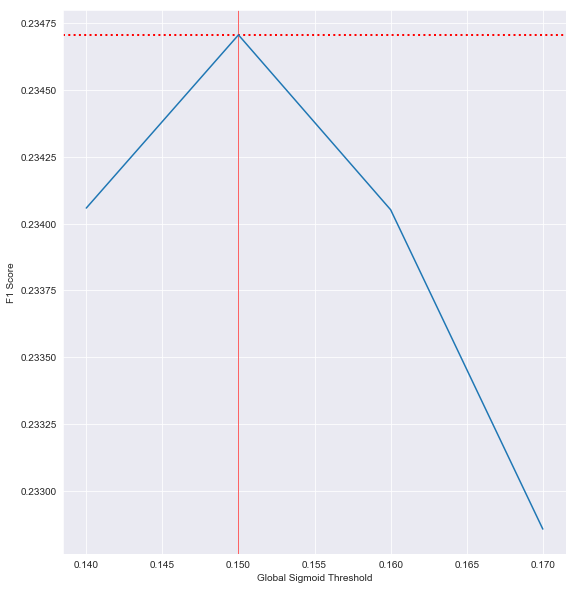

In [16]:
import seaborn as sns
sns.set_style('darkgrid')
plt.figure(figsize=(9, 10))
plt.ylabel('F1 Score')
plt.xlabel('Global Sigmoid Threshold')
plt.axhline(y=best_f_score, linestyle=':', linewidth=2, color ='r')
plt.axvline(x=best_threshold, alpha=0.6, linewidth=1, color='r')
plt.plot(t_list, f1_score_list)
plt.savefig('Grid_Search_on_Validation.jpg')
plt.show()
plt.close()

In [19]:
print("Best F1 Score on Validation Dataset: {} @ {} threshold".format(round(best_f_score,5), best_threshold))

Best F1 Score on Validation Dataset: 0.2347 @ 0.15000000000000002 threshold


In [21]:
### We found that the best F1 Score on Validation Dataset is 0.23475 at a threshold of 0.15 ###
### Now let's leave the result file for the validation images ###

In [24]:
### Create the Result File for Validation Images ###
create_result_files(filename='final_val_results.txt', raw_predictions=raw_predictions_on_val_images, generator=val_datagen, class_dict=val_datagen.class_indices, threshold=0.15)

In [30]:
### Let's Create the GT File ###
def create_gt_file(gt_df,filename='gt_val.txt'):
    filenames = gt_df['image'].values
    gt = gt_df['tags'].values
    with open(filename, "w") as text_file:
        for image, ground_truth in zip(filenames,gt):
            name = str(image)
            string_to_print = name +'\t'+ ";".join(ground_truth)
            print(string_to_print, file=text_file)
    return 

In [31]:
create_gt_file(gt_df=val_tag_id)

In [32]:
### Let's Run the Competition's Evaluation File ###

In [37]:
!python evaluate-f1.py final_val_results.txt gt_val.txt

Input parameters
********************************
Candidate file is "final_val_results.txt"
Ground Truth file is "gt_val.txt"
Processing concept sets...
********************************
1000 / 14157  concept sets processed...
2000 / 14157  concept sets processed...
3000 / 14157  concept sets processed...
4000 / 14157  concept sets processed...
5000 / 14157  concept sets processed...
6000 / 14157  concept sets processed...
7000 / 14157  concept sets processed...
8000 / 14157  concept sets processed...
9000 / 14157  concept sets processed...
10000 / 14157  concept sets processed...
11000 / 14157  concept sets processed...
12000 / 14157  concept sets processed...
13000 / 14157  concept sets processed...
14000 / 14157  concept sets processed...
Concept statistics
********************************
Number of concepts distribution
1 : 1037
2 : 1387
3 : 1615
4 : 1683
5 : 1626
6 : 1371
7 : 1242
8 : 943
9 : 794
10 : 632
11 : 456
12 : 340
13 : 275
14 : 208
15 : 136
16 : 136
17 : 64
18 : 50
19 : 36

* After finessing your model on the validation images, you will use it on the test images.

In [ ]:
### Perform the same for Test Images ###
### We created a dummy folder named dummy class in order for this to work ###

In [ ]:
datagen3 = ImageDataGenerator(rescale=1./255.)

final_generator = datagen3.flow_from_directory(directory=test_data_path,
                  target_size=(72,72),
                  classes=None,
                  batch_size=10,
                  shuffle=False,
                  seed=1453)

In [ ]:
### Predict over the Test Images ###
final_generator.reset()
raw_predictions_on_test_images = create_predictions(model=final_model, generator=final_generator)

In [ ]:
### Create the Result File for Test Images ###
create_result_files(filename='final_test_results.txt', raw_predictions=raw_predictions_on_test_images, generator=final_generator, class_dict=val_datagen.class_indices, threshold=0.15)